In [4]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

import hnn_core
import os.path as opx
import matplotlib.pyplot as plt
import time
import numpy as np
from hnn_core import jones_2009_model, simulate_dipole, read_params
from hnn_core.network_models import add_erp_drives_to_jones_model
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

--No graphics will be displayed.


In [3]:
def hnn_simulator(parameter_set):
    
    net_sim = jones_2009_model()
    
    parameter_set1 = parameter_set[0]
    parameter_set2 = parameter_set[1]
    
    
    # your code here that updates "mu" or mean time of drives using parameter theta
    weights_ampa = {'L2_basket': 0.09, 'L2_pyramidal': 0.02, 
                'L5_basket': 0.2, 'L5_pyramidal': 8e-3}
    synaptic_delays = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                   'L5_basket': 1.0, 'L5_pyramidal': 1.0}

    net_sim.add_evoked_drive(name='evprox1', mu=parameter_set1, sigma=parameter_set2, numspikes=1,
                     weights_ampa=weights_ampa, location='proximal',
                     synaptic_delays=synaptic_delays)
    
    dpl = simulate_dipole(net_sim, dt=0.5, tstop=170)

    return dpl[0].data['agg']

In [5]:
prior = utils.BoxUniform(low=[20, 0], high=[160, 30])

In [6]:
prior

BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)

In [27]:
# load x, theta
x = torch.load('x.pt')
theta = torch.load('theta.pt')

In [28]:
obv_real = hnn_simulator((90, 15))

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


In [33]:
theta_real = (90, 15)

In [29]:
# Gaussian noise

noise1 = np.random.normal(loc=0, scale=0, size=(341,))
noise2 = np.random.normal(loc=0, scale=0.001, size=(341,))
noise3 = np.random.normal(loc=0, scale=0.01, size=(341,))
noise4 = np.random.normal(loc=0, scale=0.1, size=(341,))
noise5 = np.random.normal(loc=0, scale=0.5, size=(341,))
noise6 = np.random.normal(loc=0, scale=1, size=(341,))
noise7 = np.random.normal(loc=0, scale=1.5, size=(341,))

noises = [noise1, noise2, noise3, noise4, noise5, noise6, noise7]
noise_names = ['noise_0', 'noise_0.001', 'noise_0.01', 'noise_0.1', 'noise_0.5', 'noise_1', 'noise_1.5']

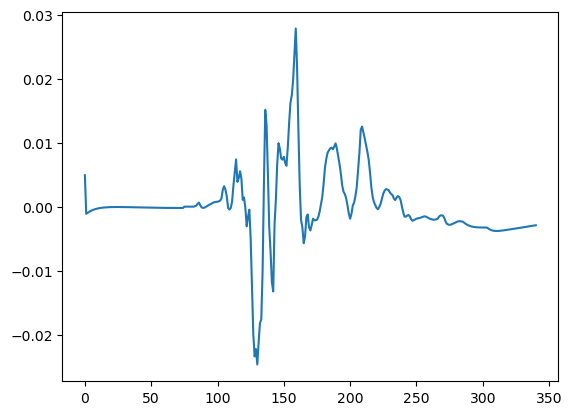

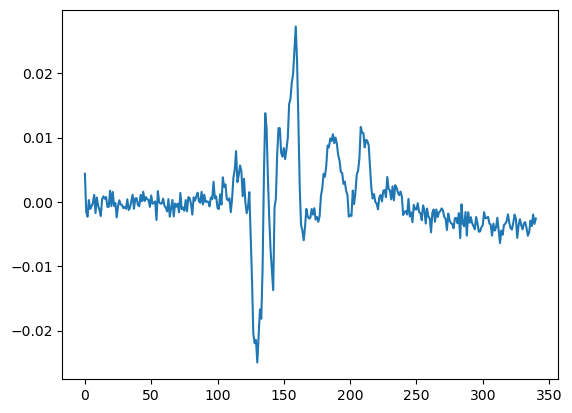

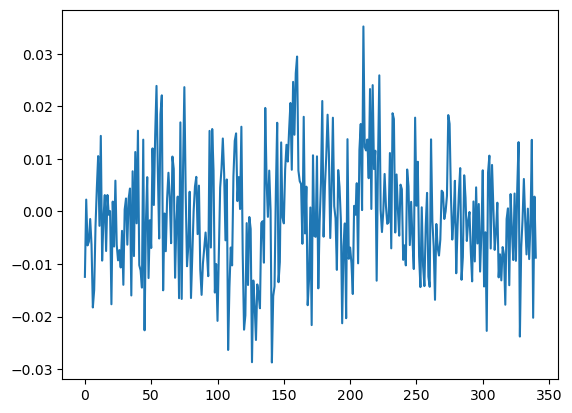

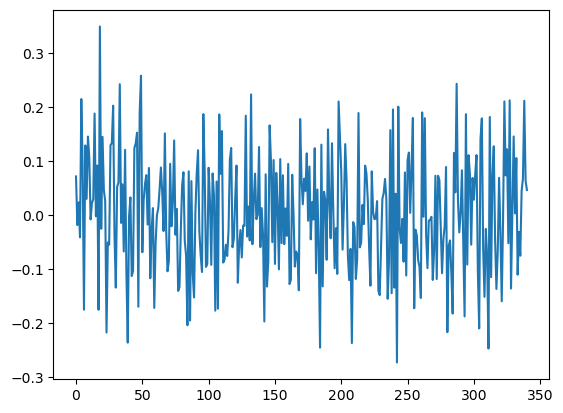

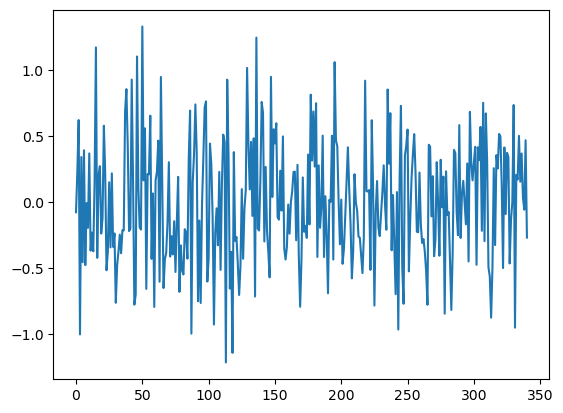

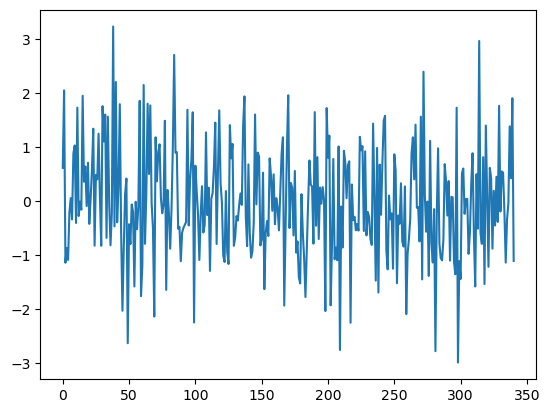

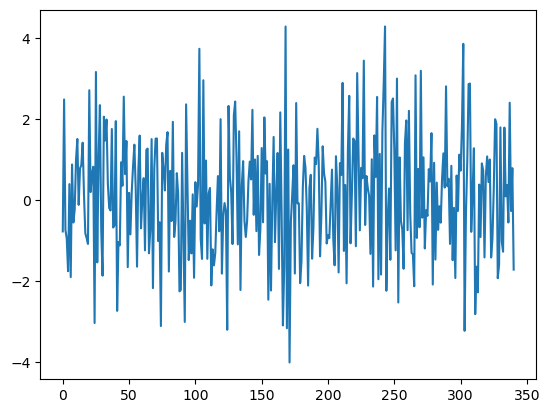

In [30]:
for noise in noises:
    obv = obv_real + noise
    plt.plot(obv.T)
    plt.show()

## Generate plots for real observations with different noises

 Neural network successfully converged after 28 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 25 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 27 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 27 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 27 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

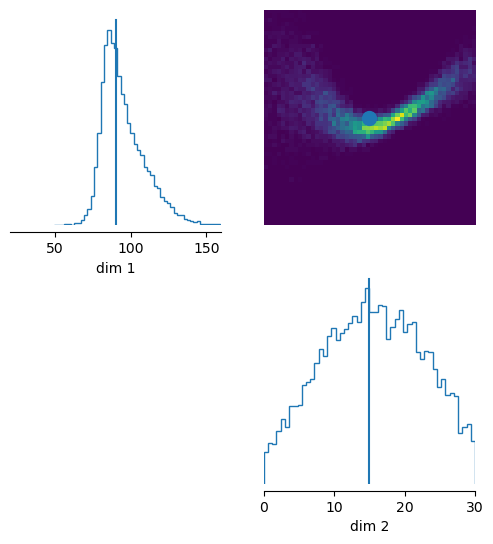

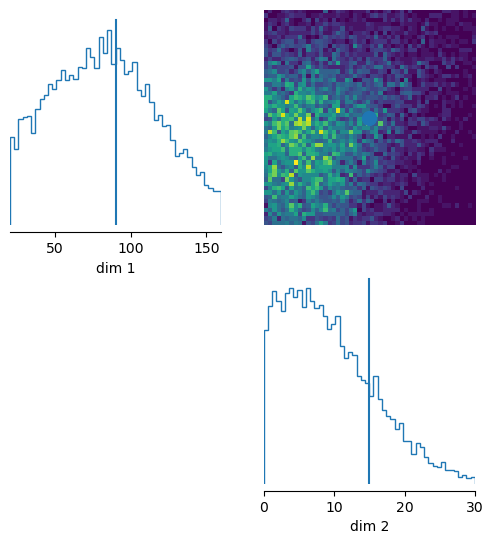

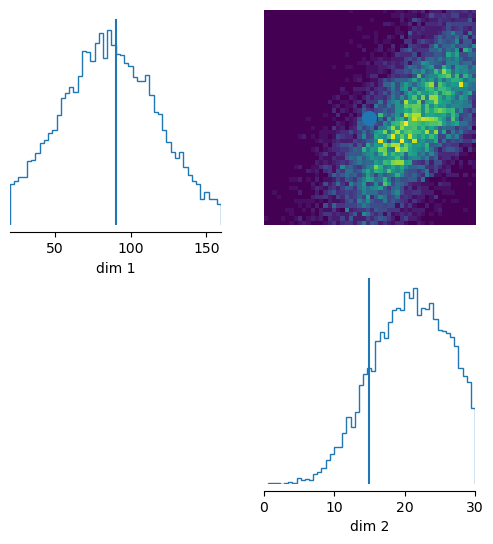

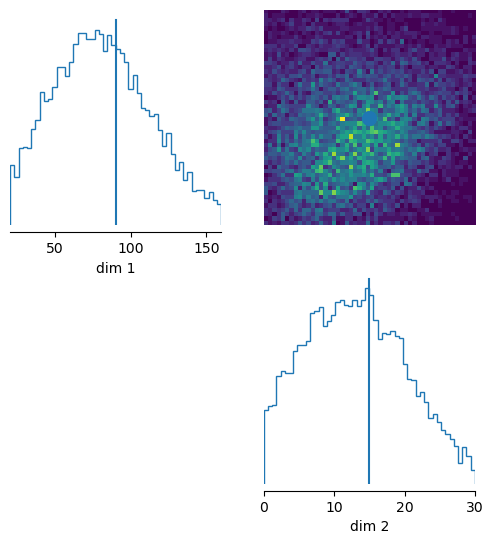

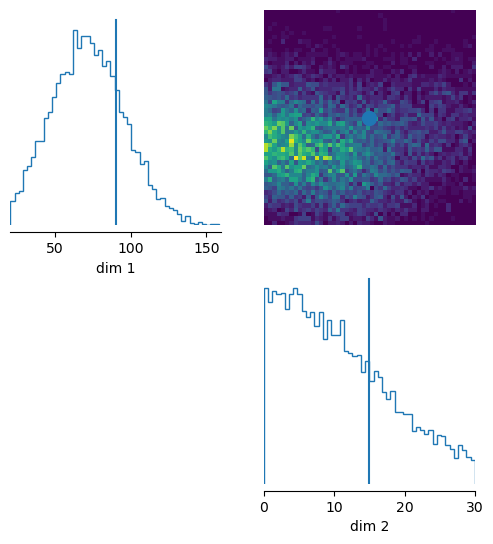

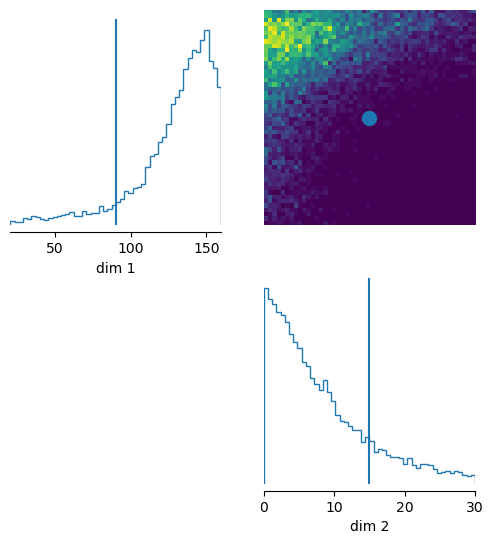

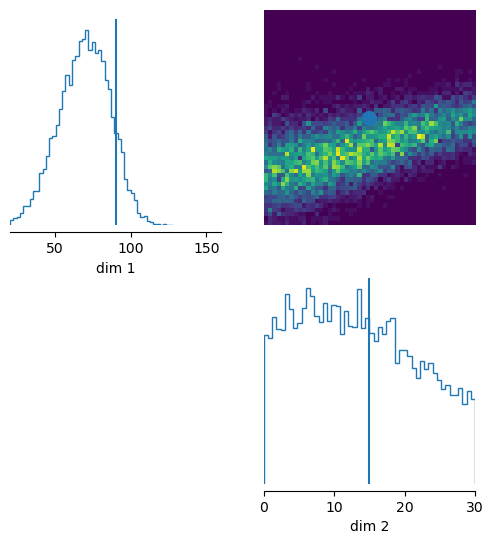

In [34]:
for noise, noise_name in zip(noises, noise_names):
    
    obv = obv_real + noise

    # train posterior
    inference = SNPE(prior)
    density_estimator = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(density_estimator)

    samples = posterior.sample((10000,), x=obv)
    log_probability = posterior.log_prob(samples, x=obv)
    _ = analysis.pairplot(samples, limits=[[20, 160], [0, 30]], figsize=(6, 6), points=theta_real)

    plt.savefig(f'figures2/real_obv_with{noise_name}.png')
    # plt.close()